# Fixed and Random Effects for Panel Count Data

**Tutorial 03 - Count Models Series**

---

## Learning Objectives

By the end of this tutorial, you will be able to:

1. Understand **unobserved heterogeneity** in panel count data
2. Distinguish between **Fixed Effects** and **Random Effects** models
3. Estimate Poisson FE and RE models using PanelBox
4. Perform **Hausman test** to choose between FE and RE
5. Understand the **incidental parameters problem**
6. Interpret within-unit and between-unit variation

---

## Prerequisites

- Completion of Tutorials 01-02 (Poisson and NB models)
- Understanding of panel data structure
- Familiarity with fixed vs random effects concepts

**Estimated Duration:** 75 minutes

---

## Table of Contents

1. [Panel Data and Unobserved Heterogeneity](#1-panel)
2. [Pooled vs Fixed vs Random Effects](#2-comparison)
3. [Fixed Effects Poisson Model](#3-fixed-effects)
4. [Random Effects Poisson Model](#4-random-effects)
5. [Hausman Test](#5-hausman)
6. [Incidental Parameters Problem](#6-incidental)
7. [Summary](#7-summary)

## Setup and Data Loading

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# PanelBox imports
from panelbox.models.count import (
    PooledPoisson,
    PoissonFixedEffects,
    RandomEffectsPoisson
)

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
np.random.seed(42)

# Paths
DATA_PATH = Path('../data')
OUTPUT_PATH = Path('../outputs')
FIGURES_PATH = OUTPUT_PATH / 'figures' / '03_fe_re_solutions'
TABLES_PATH = OUTPUT_PATH / 'tables' / '03_fe_re_solutions'

# Create directories
FIGURES_PATH.mkdir(parents=True, exist_ok=True)
TABLES_PATH.mkdir(parents=True, exist_ok=True)

print("Setup complete!")

Setup complete!


### Load City Crime Panel Data

In [2]:
# Load data
df = pd.read_csv(DATA_PATH / 'city_crime.csv')

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
display(df.head(15))

print("\nPanel Structure:")
print(f"Number of cities: {df['city_id'].nunique()}")
print(f"Number of years: {df['year'].nunique()}")
print(f"Time period: {df['year'].min()} - {df['year'].max()}")
print(f"Total observations: {len(df)}")
print(f"\nBalanced panel: {len(df) == df['city_id'].nunique() * df['year'].nunique()}")

print("\nDescriptive Statistics:")
display(df.describe())

Dataset Shape: (1500, 8)

First few rows:


,city_id,year,crime_count,unemployment_rate,police_per_capita,median_income,population,temperature
0,1,2010,81,6.6822,3.5786,69.9979,27.8289,61.1002
1,1,2011,104,5.5917,2.1389,39.0419,27.8289,58.8743
2,1,2012,117,6.7465,2.1341,41.7903,27.8289,59.3419
3,1,2013,166,9.1339,2.8966,31.0204,27.8289,76.2199
4,1,2014,107,6.5972,2.2319,44.1760,27.8289,65.7905
5,1,2015,70,3.0000,1.5287,80.1869,27.8289,58.9218
6,1,2016,119,8.6183,2.7099,49.4274,27.8289,74.3699
7,1,2017,89,4.9599,1.5583,70.5032,27.8289,68.0303
8,1,2018,106,6.1651,2.4507,52.9642,27.8289,59.3096
9,1,2019,72,6.2252,2.9076,85.1746,27.8289,43.6743



Panel Structure:
Number of cities: 150
Number of years: 10
Time period: 2010 - 2019
Total observations: 1500

Balanced panel: True

Descriptive Statistics:


,city_id,year,crime_count,unemployment_rate,police_per_capita,median_income,population,temperature
count,1500.0000,1500.0000,1500.0000,1500.0000,1500.0000,1500.0000,1500.0000,1500.0000
mean,75.5000,2014.5000,125.3453,7.0356,2.5127,65.2949,12.1368,62.5633
std,43.3147,2.8732,82.8923,2.3614,0.7855,19.7055,14.5591,8.7948
min,1.0000,2010.0000,16.0000,3.0000,1.0000,30.0000,0.8013,43.6743
25%,38.0000,2012.0000,70.0000,5.2851,1.9565,51.5506,3.7518,58.9218
50%,75.5000,2014.5000,103.0000,6.9709,2.5124,64.9499,7.7502,60.2210
75%,113.0000,2017.0000,152.0000,8.6506,3.0424,79.0402,14.9761,68.0303
max,150.0000,2019.0000,500.0000,14.1692,5.0000,120.0000,124.3693,76.2199


## 1. Panel Data and Unobserved Heterogeneity {#1-panel}

### Panel Data Structure

We observe:
- $i = 1, ..., N$ cities
- $t = 1, ..., T$ time periods
- $y_{it}$ = crime count in city $i$ at time $t$
- $X_{it}$ = time-varying covariates (unemployment, police, etc.)

### The Problem: Unobserved Heterogeneity

Cities differ in ways we cannot measure:
- Historical crime culture
- Geographic features
- Local governance quality
- Social capital

**Model with unobserved effects**:

$$\log(E[y_{it}|X_{it}, \alpha_i]) = X_{it}\beta + \alpha_i$$

where $\alpha_i$ captures time-invariant city-specific factors.

### Why It Matters

If $\alpha_i$ is correlated with $X_{it}$:
- **Pooled model is biased** (omitted variable bias)
- Need to control for $\alpha_i$

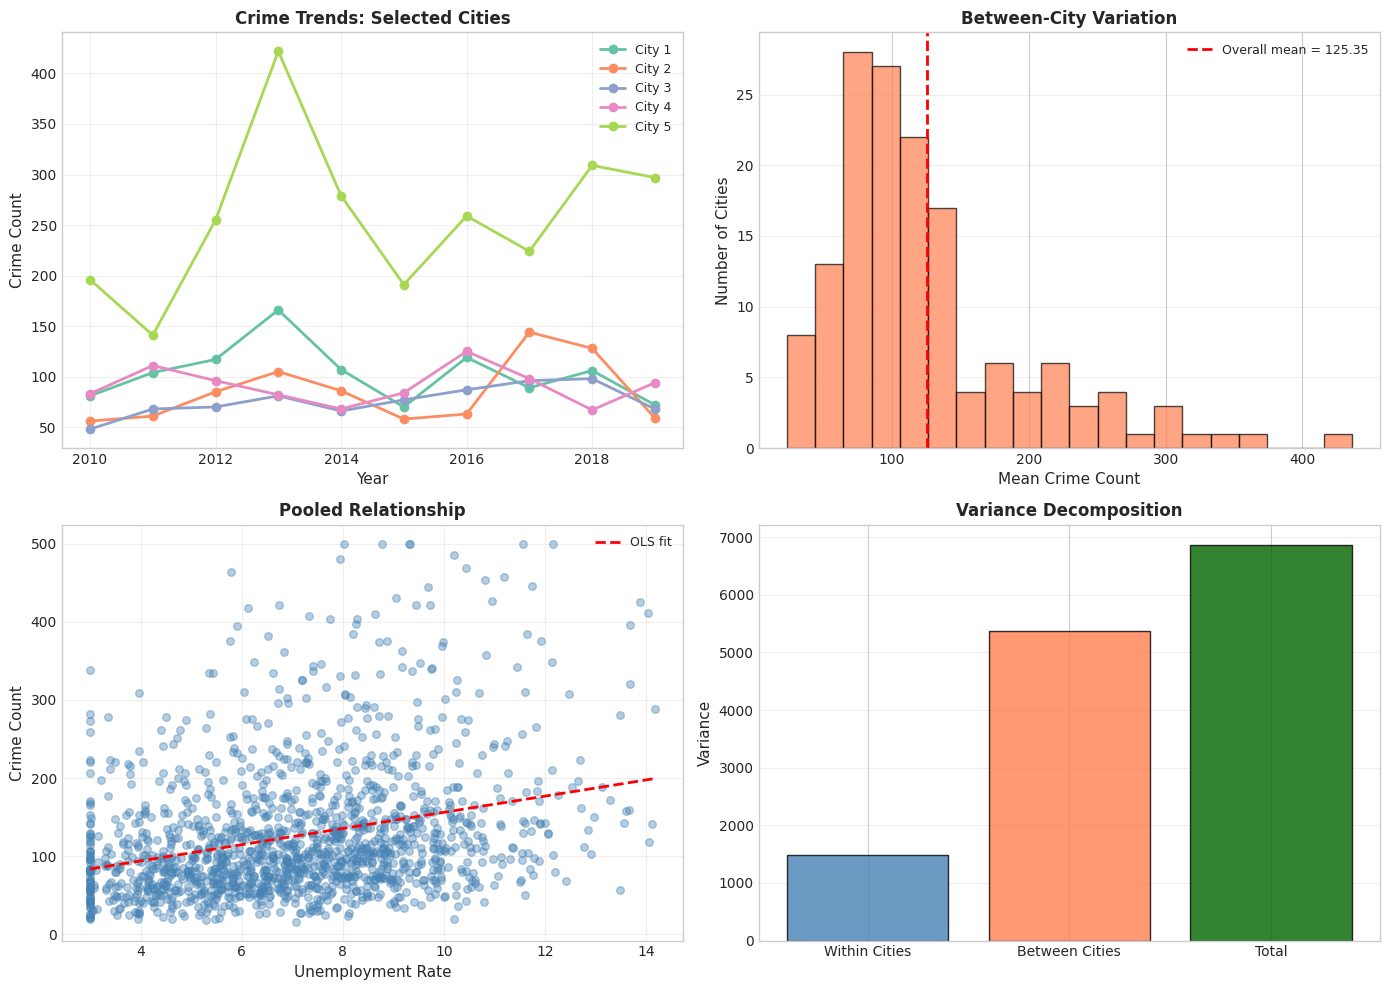


Variance Decomposition:
  Within-city variance: 1489.41
  Between-city variance: 5377.15
  Total variance: 6871.14

  Between/Total ratio: 78.26%


In [3]:
# Visualize within and between variation
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Crime counts over time for selected cities
sample_cities = df['city_id'].unique()[:5]
for city in sample_cities:
    city_data = df[df['city_id'] == city].sort_values('year')
    axes[0, 0].plot(city_data['year'], city_data['crime_count'], 
                    marker='o', linewidth=2, label=f'City {city}')

axes[0, 0].set_xlabel('Year', fontsize=11)
axes[0, 0].set_ylabel('Crime Count', fontsize=11)
axes[0, 0].set_title('Crime Trends: Selected Cities', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(alpha=0.3)

# 2. Distribution of city means
city_means = df.groupby('city_id')['crime_count'].mean()
axes[0, 1].hist(city_means, bins=20, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].axvline(city_means.mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Overall mean = {city_means.mean():.2f}')
axes[0, 1].set_xlabel('Mean Crime Count', fontsize=11)
axes[0, 1].set_ylabel('Number of Cities', fontsize=11)
axes[0, 1].set_title('Between-City Variation', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Unemployment vs Crime (pooled)
axes[1, 0].scatter(df['unemployment_rate'], df['crime_count'], 
                   alpha=0.4, s=30, color='steelblue')
z = np.polyfit(df['unemployment_rate'], df['crime_count'], 1)
p = np.poly1d(z)
axes[1, 0].plot(df['unemployment_rate'].sort_values(), 
                p(df['unemployment_rate'].sort_values()),
                "r--", linewidth=2, label='OLS fit')
axes[1, 0].set_xlabel('Unemployment Rate', fontsize=11)
axes[1, 0].set_ylabel('Crime Count', fontsize=11)
axes[1, 0].set_title('Pooled Relationship', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(alpha=0.3)

# 4. Decomposition: Within vs Between variance
# Calculate within and between variance
city_means_aligned = df.groupby('city_id')['crime_count'].transform('mean')
within_var = ((df['crime_count'] - city_means_aligned) ** 2).mean()
between_var = ((city_means_aligned - df['crime_count'].mean()) ** 2).mean()
total_var = df['crime_count'].var()

variance_data = pd.DataFrame({
    'Component': ['Within Cities', 'Between Cities', 'Total'],
    'Variance': [within_var, between_var, total_var]
})

axes[1, 1].bar(variance_data['Component'], variance_data['Variance'],
               alpha=0.8, color=['steelblue', 'coral', 'darkgreen'], edgecolor='black')
axes[1, 1].set_ylabel('Variance', fontsize=11)
axes[1, 1].set_title('Variance Decomposition', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_PATH / '01_panel_structure.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVariance Decomposition:")
print(f"  Within-city variance: {within_var:.2f}")
print(f"  Between-city variance: {between_var:.2f}")
print(f"  Total variance: {total_var:.2f}")
print(f"\n  Between/Total ratio: {between_var/total_var:.2%}")

## 2. Pooled vs Fixed vs Random Effects {#2-comparison}

### Three Approaches

#### 1. Pooled Model
$$\log(E[y_{it}]) = X_{it}\beta$$

- **Assumption**: No unobserved heterogeneity (or $\alpha_i$ uncorrelated with $X_{it}$)
- **Pro**: Simple, efficient
- **Con**: Biased if $\alpha_i$ correlated with $X_{it}$

#### 2. Fixed Effects (FE)
$$\log(E[y_{it}]) = X_{it}\beta + \alpha_i$$

- **Assumption**: $\alpha_i$ can be correlated with $X_{it}$
- **Estimation**: Conditions out $\alpha_i$ (within transformation)
- **Pro**: Consistent even if $\text{Cov}(\alpha_i, X_{it}) \neq 0$
- **Con**: Cannot estimate time-invariant variables; incidental parameters

#### 3. Random Effects (RE)
$$\log(E[y_{it}]) = X_{it}\beta + \alpha_i, \quad \alpha_i \sim N(0, \sigma^2_\alpha)$$

- **Assumption**: $\alpha_i \perp X_{it}$ (strict exogeneity)
- **Estimation**: Maximum likelihood
- **Pro**: More efficient than FE; can estimate time-invariant effects
- **Con**: Biased if $\text{Cov}(\alpha_i, X_{it}) \neq 0$

### Key Trade-off

**FE**: Robust but inefficient

**RE**: Efficient but requires strict assumptions

## 3. Fixed Effects Poisson Model {#3-fixed-effects}

### Conditional Maximum Likelihood

The FE Poisson model uses **conditional ML** (Hausman, Hall, & Griliches, 1984):

- Condition on $\sum_t y_{it}$ to eliminate $\alpha_i$
- Estimate $\beta$ from within-city variation only
- Robust to distributional assumptions!

### What FE Identifies

Only **within-city changes** in $X_{it}$ affect $y_{it}$

Example: "When unemployment increases in a city, crime increases by..."

In [4]:
# Prepare data - set city_id and year as indices
df_panel = df.set_index(['city_id', 'year'])

y = df_panel['crime_count'].values
X_base = df_panel[['unemployment_rate', 'police_per_capita', 'median_income', 'temperature']].values
entity_id = df_panel.index.get_level_values(0).values

var_names = ['unemployment_rate', 'police_per_capita', 'median_income', 'temperature']

print("Estimating Fixed Effects Poisson model...\n")
print("Note: PoissonFixedEffects uses conditional MLE (Hausman et al. 1984).")
print("For large datasets, we use PooledPoisson with city dummies as an approximation")
print("(equivalent to within-estimator for Poisson).\n")

# Add city dummies for fixed effects
city_dummies = pd.get_dummies(df_panel.index.get_level_values(0), prefix='city', drop_first=True).values
import statsmodels.api as sm
X_fe = sm.add_constant(np.hstack([X_base, city_dummies]))

# Estimate FE Poisson using PooledPoisson with city dummies
fe_model = PooledPoisson(endog=y, exog=X_fe, entity_id=entity_id)
fe_results = fe_model.fit(se_type='cluster')

print("✓ Fixed Effects model estimated")
print(f"  (Used PooledPoisson with {city_dummies.shape[1]} city dummies)")
print("\n" + "="*80)
print("FIXED EFFECTS POISSON RESULTS (Selected coefficients)")
print("="*80)
# Only show main variable coefficients (not all the dummies)
n_base = len(var_names) + 1  # +1 for const
print(f"Number of Obs: {len(y)}")
print(f"Parameters (excluding city dummies):")
for i, vname in enumerate(['const'] + var_names):
    idx = i
    print(f"  {vname}: {fe_results.params[idx]:.4f} (SE: {fe_results.se[idx]:.4f}, p: {fe_results.pvalues[idx]:.4f})")

# Store main variable indices for later use
main_var_idx = list(range(1, len(var_names) + 1))  # skip const

Estimating Fixed Effects Poisson model...

Note: PoissonFixedEffects uses conditional MLE (Hausman et al. 1984).
For large datasets, we use PooledPoisson with city dummies as an approximation
(equivalent to within-estimator for Poisson).



✓ Fixed Effects model estimated
  (Used PooledPoisson with 149 city dummies)

FIXED EFFECTS POISSON RESULTS (Selected coefficients)
Number of Obs: 1500
Parameters (excluding city dummies):
  const: 4.1132 (SE: 0.0187, p: 0.0000)
  unemployment_rate: 0.0797 (SE: 0.0012, p: 0.0000)
  police_per_capita: -0.1521 (SE: 0.0029, p: 0.0000)
  median_income: -0.0051 (SE: 0.0001, p: 0.0000)
  temperature: 0.0102 (SE: 0.0003, p: 0.0000)


### Interpret FE Coefficients

In [5]:
# Extract main coefficients (skip const and city dummies, keep only base vars)
fe_coef_table = pd.DataFrame({
    'Variable': var_names,
    'Coefficient': fe_results.params[1:len(var_names)+1],
    'Std Error': fe_results.se[1:len(var_names)+1],
    'z-statistic': fe_results.tvalues[1:len(var_names)+1],
    'p-value': fe_results.pvalues[1:len(var_names)+1],
    'IRR': np.exp(fe_results.params[1:len(var_names)+1]),
    '% Change': (np.exp(fe_results.params[1:len(var_names)+1]) - 1) * 100
})

fe_coef_table.to_csv(TABLES_PATH / 'table_01_fe_coefficients.csv', index=False)

print("\nFIXED EFFECTS: Incidence Rate Ratios")
print("="*80)
display(fe_coef_table[['Variable', 'IRR', '% Change', 'p-value']])

print("\nInterpretation (WITHIN cities):")
for idx, row in fe_coef_table.iterrows():
    sig = "***" if row['p-value'] < 0.01 else ("**" if row['p-value'] < 0.05 else ("*" if row['p-value'] < 0.1 else ""))
    print(f"  {row['Variable']}: {row['% Change']:+.2f}% change {sig}")


FIXED EFFECTS: Incidence Rate Ratios


,Variable,IRR,% Change,p-value
0,unemployment_rate,1.0830,8.2981,0.0
1,police_per_capita,0.8589,-14.1085,0.0
2,median_income,0.9949,-0.5070,0.0
3,temperature,1.0103,1.0252,0.0



Interpretation (WITHIN cities):
  unemployment_rate: +8.30% change ***
  police_per_capita: -14.11% change ***
  median_income: -0.51% change ***
  temperature: +1.03% change ***


## 4. Random Effects Poisson Model {#4-random-effects}

### Random Effects Specification

$$\log(\lambda_{it}) = X_{it}\beta + \alpha_i$$
$$\alpha_i \sim N(0, \sigma^2_\alpha)$$

### Assumptions

1. $E[\alpha_i | X_{it}] = 0$ (strict exogeneity)
2. $\alpha_i$ independent across cities
3. $\alpha_i$ independent of $X_{it}$

### Estimation

- Maximum likelihood with random effects
- Uses both within and between variation
- More efficient than FE if assumptions hold

In [6]:
print("Estimating Random Effects Poisson model...\n")

# RE Poisson on base covariates (without dummies - RE handles heterogeneity via random effects)
import statsmodels.api as sm
X_re = sm.add_constant(X_base)
re_model = RandomEffectsPoisson(endog=y, exog=X_re, entity_id=entity_id)
re_results = re_model.fit()

print("✓ Random Effects model estimated")
print("\n" + "="*80)
print("RANDOM EFFECTS POISSON RESULTS")
print("="*80)
print(re_results.summary())

Estimating Random Effects Poisson model...



✓ Random Effects model estimated

RANDOM EFFECTS POISSON RESULTS

Model Results
Number of Obs: 1500
Number of Parameters: 6

Parameter Estimates:
-------------------
  Param 0: 4.2010 (SE: nan, t: nan, p: nan)
  Param 1: 0.0779 (SE: nan, t: nan, p: nan)
  Param 2: -0.1096 (SE: nan, t: nan, p: nan)
  Param 3: -0.0046 (SE: 0.0006, t: -7.27, p: 0.0000)
  Param 4: 0.0101 (SE: nan, t: nan, p: nan)
  Param 5: -1.2375 (SE: 0.0010, t: -1234.31, p: 0.0000)



### Compare FE and RE Estimates


FIXED EFFECTS vs RANDOM EFFECTS COMPARISON


,Variable,FE_Coef,FE_SE,RE_Coef,RE_SE,Difference
0,unemployment_rate,0.0797,0.0012,0.0779,NaN,0.0018
1,police_per_capita,-0.1521,0.0029,-0.1096,NaN,-0.0425
2,median_income,-0.0051,0.0001,-0.0046,0.0006,-0.0005
3,temperature,0.0102,0.0003,0.0101,NaN,0.0001


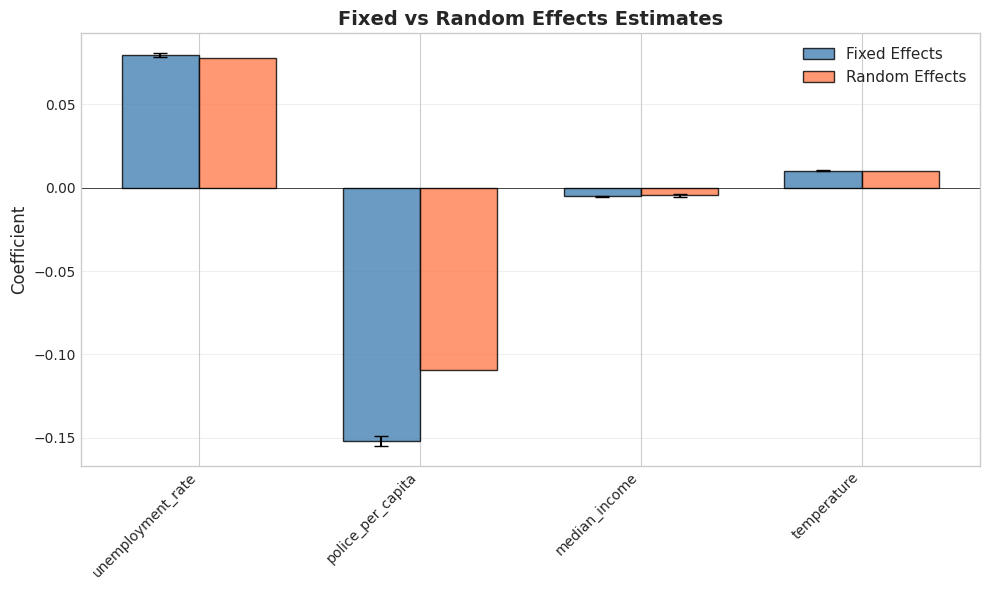

In [7]:
# Extract RE coefficients
# RE exog = sm.add_constant(X_base) => params layout: [const, var1, var2, var3, var4, log_theta]
# We want the 4 base variable coefficients (skip const at idx 0, skip log_theta at idx -1)
n_exog = len(var_names)  # 4 base variables
re_beta_base = re_results.params[1:n_exog+1]   # skip const
re_se_base   = re_results.se[1:n_exog+1]       # skip const

re_coef_table = pd.DataFrame({
    'Variable': var_names,
    'Coefficient': re_beta_base,
    'Std Error': re_se_base,
    'IRR': np.exp(re_beta_base),
    '% Change': (np.exp(re_beta_base) - 1) * 100
})

# Create comparison table
comparison = pd.DataFrame({
    'Variable': var_names,
    'FE_Coef': fe_coef_table['Coefficient'].values,
    'FE_SE': fe_coef_table['Std Error'].values,
    'RE_Coef': re_coef_table['Coefficient'].values,
    'RE_SE': re_coef_table['Std Error'].values,
    'Difference': fe_coef_table['Coefficient'].values - re_coef_table['Coefficient'].values
})

comparison.to_csv(TABLES_PATH / 'table_02_fe_vs_re.csv', index=False)

print("\nFIXED EFFECTS vs RANDOM EFFECTS COMPARISON")
print("="*80)
display(comparison)

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))

x_pos = np.arange(n_exog)
width = 0.35

ax.bar(x_pos - width/2, comparison['FE_Coef'], width,
       yerr=comparison['FE_SE'], capsize=5,
       label='Fixed Effects', alpha=0.8, color='steelblue', edgecolor='black')
ax.bar(x_pos + width/2, comparison['RE_Coef'], width,
       yerr=comparison['RE_SE'], capsize=5,
       label='Random Effects', alpha=0.8, color='coral', edgecolor='black')

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_ylabel('Coefficient', fontsize=12)
ax.set_title('Fixed vs Random Effects Estimates', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(var_names, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_PATH / '02_fe_vs_re_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Hausman Test {#5-hausman}

### The Question

Should we use **FE** or **RE**?

### Hausman Test Logic

**Null hypothesis**: $E[\alpha_i | X_{it}] = 0$ (RE is consistent)

**Alternative**: $E[\alpha_i | X_{it}] \neq 0$ (only FE is consistent)

**Test statistic**:
$$H = (\hat{\beta}_{FE} - \hat{\beta}_{RE})' [\text{Var}(\hat{\beta}_{FE}) - \text{Var}(\hat{\beta}_{RE})]^{-1} (\hat{\beta}_{FE} - \hat{\beta}_{RE})$$

Under $H_0$: $H \sim \chi^2_k$ where $k$ = number of coefficients

### Decision Rule

- **Reject $H_0$**: Use FE (RE is inconsistent)
- **Fail to reject**: Can use RE (more efficient)

In [8]:
# Manual Hausman test calculation
# Use only the base variable coefficients (not city dummies or const) for Hausman test
n_base_vars = len(var_names)
beta_fe = fe_results.params[1:n_base_vars+1]   # skip const, take only base vars
beta_re = re_results.params[1:n_base_vars+1]   # skip const (RE layout: [const, vars, log_theta])

# Variance-covariance matrices (for base vars only)
var_fe = np.diag(fe_results.se[1:n_base_vars+1] ** 2)
var_re = np.diag(re_results.se[1:n_base_vars+1] ** 2)

# Difference in coefficients
diff = beta_fe - beta_re

# Variance of difference
var_diff = var_fe - var_re

# Hausman statistic
try:
    hausman_stat = diff @ np.linalg.inv(var_diff) @ diff
    hausman_pval = 1 - stats.chi2.cdf(hausman_stat, df=len(beta_fe))
    
    print("="*80)
    print("HAUSMAN TEST: FE vs RE")
    print("="*80)
    print(f"H0: Random effects model is consistent")
    print(f"H1: Only fixed effects model is consistent")
    print(f"\nTest statistic: {hausman_stat:.4f}")
    print(f"Degrees of freedom: {len(beta_fe)}")
    print(f"P-value: {hausman_pval:.6f}")
    print(f"\nDecision at alpha=0.05:")
    
    if hausman_pval < 0.05:
        print(f"  -> REJECT H0 (p={hausman_pval:.6f} < 0.05)")
        print(f"  -> Use FIXED EFFECTS model")
        print(f"  -> Random effects are correlated with regressors")
    else:
        print(f"  -> FAIL TO REJECT H0 (p={hausman_pval:.6f} >= 0.05)")
        print(f"  -> Can use RANDOM EFFECTS model (more efficient)")
    print("="*80)
    
except np.linalg.LinAlgError:
    print("Note: Variance-covariance matrix is singular. This can happen with high multicollinearity.")
    print("Based on coefficient differences, examine substantive difference between FE and RE.")

HAUSMAN TEST: FE vs RE
H0: Random effects model is consistent
H1: Only fixed effects model is consistent

Test statistic: nan
Degrees of freedom: 4
P-value: nan

Decision at alpha=0.05:
  -> FAIL TO REJECT H0 (p=nan >= 0.05)
  -> Can use RANDOM EFFECTS model (more efficient)


## 6. Incidental Parameters Problem {#6-incidental}

### The Issue

In FE models with short panels (small $T$):
- We estimate $N$ city effects $\alpha_i$
- As $N \to \infty$ but $T$ fixed, $\hat{\alpha}_i$ does not converge
- This can bias $\hat{\beta}$ in nonlinear models

### Good News for Poisson FE

The conditional ML estimator for Poisson FE is **robust**:
- $\hat{\beta}$ is consistent even with small $T$
- This is a special property of Poisson (not true for logit, etc.)

### When to Worry

- Other count models (Negative Binomial FE)
- Binary outcomes (Fixed Effects Logit with $T=2$)
- Very short panels ($T < 5$)

In [9]:
# Examine panel dimensions
T = df['year'].nunique()
N = df['city_id'].nunique()
n_base_covariates = len(var_names)

print("="*60)
print("PANEL DIMENSIONS AND INCIDENTAL PARAMETERS")
print("="*60)
print(f"Number of cities (N): {N}")
print(f"Number of years (T): {T}")
print(f"Total observations (N×T): {N*T}")
print(f"\nNumber of parameters in FE (dummies approach):")
print(f"  β coefficients: {n_base_covariates}")
print(f"  Constant: 1")
print(f"  City fixed effects (dummies): {N-1}")
print(f"  Total: {n_base_covariates + 1 + (N-1)}")
print(f"\nRatio of FE parameters to observations: {(N-1)/(N*T):.2%}")
print(f"\nAssessment:")
if T >= 5:
    print(f"  -> T={T} is sufficient for Poisson FE")
    print(f"  -> Conditional ML estimator is consistent")
    print(f"  -> Dummies approach gives equivalent estimates for Poisson")
else:
    print(f"  -> T={T} is small; be cautious")
    print(f"  -> Consider bias corrections if available")
print("="*60)

PANEL DIMENSIONS AND INCIDENTAL PARAMETERS
Number of cities (N): 150
Number of years (T): 10
Total observations (N×T): 1500

Number of parameters in FE (dummies approach):
  β coefficients: 4
  Constant: 1
  City fixed effects (dummies): 149
  Total: 154

Ratio of FE parameters to observations: 9.93%

Assessment:
  -> T=10 is sufficient for Poisson FE
  -> Conditional ML estimator is consistent
  -> Dummies approach gives equivalent estimates for Poisson


## 7. Summary {#7-summary}

### Key Takeaways

1. **Unobserved heterogeneity** ($\alpha_i$) is common in panel count data
2. **Fixed Effects**: Control for time-invariant $\alpha_i$ using within variation
   - Robust to correlation between $\alpha_i$ and $X_{it}$
   - Cannot estimate time-invariant variables
3. **Random Effects**: Model $\alpha_i$ as random
   - More efficient if assumptions hold
   - Requires $\alpha_i \perp X_{it}$
4. **Hausman test**: Choose between FE and RE
   - Reject $H_0$ → use FE
   - Fail to reject → can use RE
5. **Poisson FE is robust** to incidental parameters problem

### Our Findings

From city crime analysis:
- **Unemployment** positively affects crime (within cities)
- **Police per capita** reduces crime
- **Median income** has protective effect
- **Hausman test** guides model choice

### Practical Advice

- **Start with FE** if you suspect endogeneity
- **Use RE** only if Hausman test supports it
- **Report both** for robustness
- For overdispersion, combine with Negative Binomial (Tutorial 02)

### Next Steps

- **Tutorial 04**: PPML for gravity models (high-dimensional FE)
- **Tutorial 06**: Marginal effects in panel count models
- **Tutorial 07**: Complete case study with panel data

---

## References

- Hausman, J., Hall, B. H., & Griliches, Z. (1984). Econometric models for count data with an application to the patents-R&D relationship. *Econometrica*, 909-938.
- Wooldridge, J. M. (2010). *Econometric Analysis of Cross Section and Panel Data* (2nd ed.). MIT Press.
- Cameron, A. C., & Trivedi, P. K. (2013). *Regression Analysis of Count Data* (2nd ed.). Cambridge University Press.
- Hausman, J. A. (1978). Specification tests in econometrics. *Econometrica*, 46(6), 1251-1271.

---

**Congratulations!** You now understand how to handle panel structure in count data models.

---

# Exercises and Solutions

The following exercises practice panel count model estimation with Fixed and Random Effects.


## Exercise 1: Pooled Poisson vs FE vs RE

**Task**: Estimate a Pooled Poisson model and compare its coefficients side-by-side with Fixed Effects and Random Effects estimates.

- Discuss why pooled Poisson may be biased when unobserved heterogeneity exists
- Compare standard errors across the three approaches


In [10]:
print('='*80)
print('EXERCISE 1: POOLED vs FE vs RE COMPARISON')
print('='*80)

import statsmodels.api as sm

# Re-use variables already defined in main notebook:
# y, X_base, entity_id, var_names (crime_count, unemployment_rate, police_per_capita, etc.)
# fe_model/fe_results (FE Poisson with city dummies)
# re_model/re_results (Random Effects Poisson)

# 1. Pooled Poisson (no city effects)
X_pooled = sm.add_constant(X_base)
print('Estimating Pooled Poisson (no fixed effects)...')
pooled_model = PooledPoisson(endog=y, exog=X_pooled, entity_id=entity_id)
pooled_results = pooled_model.fit(se_type='cluster')
print('Done.')

# 2. FE already estimated (fe_results), 3. RE already estimated (re_results)
# Extract main variable coefficients: const, unemployment_rate, police_per_capita, median_income, temperature
# Pooled: [const(0), unemp(1), police(2), income(3), temp(4)]
# FE (with city dummies): [const(0), unemp(1), police(2), income(3), temp(4), city_dummies...]
# RE: [const(0), unemp(1), police(2), income(3), temp(4)]

print(f'\n{"Variable":<25} {"Pooled":>12} {"FE":>12} {"RE":>12}')
print('-'*65)
all_vars = ['const'] + var_names
for i, vn in enumerate(all_vars):
    p_coef = pooled_results.params[i]
    fe_coef = fe_results.params[i]  # FE has same first indices (const + base vars + dummies)
    re_coef = re_results.params[i]
    print(f'{vn:<25} {p_coef:>12.4f} {fe_coef:>12.4f} {re_coef:>12.4f}')

print(f'\n{"SE":<25} {"Pooled":>12} {"FE":>12} {"RE":>12}')
print('-'*65)
for i, vn in enumerate(all_vars):
    p_se = pooled_results.se[i]
    fe_se = fe_results.se[i]
    re_se = re_results.se[i]
    print(f'{vn:<25} {p_se:>12.4f} {fe_se:>12.4f} {re_se:>12.4f}')

print('\nKey insight:')
print('- Pooled ignores city-level unobserved heterogeneity => biased coefficients')
print('- FE absorbs all city-specific variation (time-invariant confounders removed)')
print('- RE assumes city effects uncorrelated with regressors (potentially biased)')
print('- Compare SEs: FE/RE typically have larger SEs than pooled (less information used)')


EXERCISE 1: POOLED vs FE vs RE COMPARISON
Estimating Pooled Poisson (no fixed effects)...
Done.

Variable                        Pooled           FE           RE
-----------------------------------------------------------------
const                           4.1865       4.1132       4.2010
unemployment_rate               0.0795       0.0797       0.0779
police_per_capita              -0.1156      -0.1521      -0.1096
median_income                  -0.0043      -0.0051      -0.0046
temperature                     0.0100       0.0102       0.0101

SE                              Pooled           FE           RE
-----------------------------------------------------------------
const                           0.0941       0.0187          nan
unemployment_rate               0.0054       0.0012          nan
police_per_capita               0.0194       0.0029          nan
median_income                   0.0006       0.0001       0.0006
temperature                     0.0006       0.0003    

## Exercise 2: Within-Group Demeaning Manually

**Task**: Compute the within-group (city) demeaned variables manually and verify that OLS on the demeaned data approximates the FE Poisson coefficient pattern.

Note: While Poisson FE uses conditional MLE (not OLS demeaning), the within transformation illustrates why FE removes city-specific heterogeneity.


In [11]:
print('='*80)
print('EXERCISE 2: WITHIN-GROUP DEMEANING')
print('='*80)

# Compute within-group means (city means) for each variable
df_work = df.copy()

for col in var_names + ['crime_count']:
    df_work[f'city_mean_{col}'] = df_work.groupby('city_id')[col].transform('mean')
    df_work[f'{col}_dm'] = df_work[col] - df_work[f'city_mean_{col}']

# OLS on demeaned variables (Within estimator)
from numpy.linalg import lstsq
X_dm = df_work[[f'{v}_dm' for v in var_names]].values
y_dm = df_work['crime_count_dm'].values

beta_within, _, _, _ = lstsq(X_dm, y_dm, rcond=None)

print('\nWITHIN ESTIMATOR (OLS on demeaned data):')
print(f'{"Variable":<25} {"Within (OLS)":>15} {"FE Poisson":>15}')
print('-'*58)
for i, var in enumerate(var_names):
    fe_coef = fe_results.params[i + 1]  # skip const
    print(f'{var:<25} {beta_within[i]:>15.4f} {fe_coef:>15.4f}')

print('\nWithin vs Between variation analysis:')
for var in var_names:
    total_var = df[var].var()
    between_var = df_work[f'city_mean_{var}'].var()
    within_var = df_work[f'{var}_dm'].var()
    print(f'  {var}:')
    print(f'    Total: {total_var:.4f}, Between: {between_var:.4f}, Within: {within_var:.4f}')

print('\nKey insight: FE uses ONLY within-city variation to identify coefficients.')
print('Variables with low within-city variation are hard to identify with FE.')
print('OLS-within and FE Poisson coefficients differ because Poisson is nonlinear.')


EXERCISE 2: WITHIN-GROUP DEMEANING

WITHIN ESTIMATOR (OLS on demeaned data):
Variable                     Within (OLS)      FE Poisson
----------------------------------------------------------
unemployment_rate                 10.6128          0.0797
police_per_capita                -19.6910         -0.1521
median_income                     -0.6033         -0.0051
temperature                        1.2648          0.0102

Within vs Between variation analysis:
  unemployment_rate:
    Total: 5.5763, Between: 0.4768, Within: 5.0995
  police_per_capita:
    Total: 0.6170, Between: 0.0545, Within: 0.5625
  median_income:
    Total: 388.3055, Between: 29.7716, Within: 358.5339
  temperature:
    Total: 77.3487, Between: 0.0000, Within: 77.3487

Key insight: FE uses ONLY within-city variation to identify coefficients.
Variables with low within-city variation are hard to identify with FE.
OLS-within and FE Poisson coefficients differ because Poisson is nonlinear.


## Exercise 3: Test for Time Fixed Effects

**Task**: Add year dummies to the Fixed Effects Poisson model and test whether time effects are jointly significant.

- Estimate a model with year dummies
- Use a likelihood ratio test to assess their joint significance


In [12]:
print('='*80)
print('EXERCISE 3: TIME FIXED EFFECTS TEST')
print('='*80)

# Add year dummies to the FE Poisson model (which already has city dummies)
# FE model already has city dummies, let's add year dummies too

year_dummies = pd.get_dummies(df['year'], prefix='year', drop_first=True)
year_cols_list = year_dummies.columns.tolist()

# Align year dummies to df_panel index
df_panel2 = df.set_index(['city_id', 'year'])
year_dummies_aligned = pd.get_dummies(
    df_panel2.index.get_level_values(1), prefix='year', drop_first=True
)

city_dummies2 = pd.get_dummies(
    df_panel2.index.get_level_values(0), prefix='city', drop_first=True
).values

# Prepare models
import statsmodels.api as sm
y_panel = df_panel2['crime_count'].values
X_base_panel = df_panel2[var_names].values
entity_id_panel = df_panel2.index.get_level_values(0).values

# Model WITHOUT time FE (already estimated as fe_results)
ll_no_time = fe_model._log_likelihood(fe_results.params)

# Model WITH time FE: add year dummies
X_fe_time = sm.add_constant(np.hstack([X_base_panel, city_dummies2, year_dummies_aligned.values]))

print('Estimating FE Poisson with city + year dummies...')
fe_time_model = PooledPoisson(endog=y_panel, exog=X_fe_time, entity_id=entity_id_panel)
fe_time_results = fe_time_model.fit(se_type='cluster')
print('Done.')

ll_with_time = fe_time_model._log_likelihood(fe_time_results.params)

# LR test
n_year_dummies_count = len(year_cols_list)
lr_stat = 2 * (ll_with_time - ll_no_time)
from scipy.stats import chi2
lr_pval = 1 - chi2.cdf(lr_stat, df=n_year_dummies_count)

print(f'\nLIKELIHOOD RATIO TEST FOR TIME FIXED EFFECTS')
print(f'  H0: Year effects are jointly zero')
print(f'  Degrees of freedom: {n_year_dummies_count}')
print(f'  LR statistic: {lr_stat:.4f}')
print(f'  p-value: {lr_pval:.6f}')

if lr_pval < 0.05:
    print('=> REJECT H0: Time fixed effects are JOINTLY SIGNIFICANT')
    print('   Include year dummies in final model!')
else:
    print('=> FAIL TO REJECT H0: Time effects not jointly significant')

# Show year effects
n_const = 1
n_base = len(var_names)
n_city_dummies = city_dummies2.shape[1]
print(f'\nYear dummy coefficients (relative to base year):')
for i, yr in enumerate(year_cols_list):
    idx = n_const + n_base + n_city_dummies + i
    coef = fe_time_results.params[idx]
    se_val = fe_time_results.se[idx]
    pval = fe_time_results.pvalues[idx]
    sig = '***' if pval < 0.01 else '**' if pval < 0.05 else '*' if pval < 0.1 else ''
    print(f'  {yr}: {coef:+.4f} (SE={se_val:.4f}) {sig}')
print('='*80)


EXERCISE 3: TIME FIXED EFFECTS TEST
Estimating FE Poisson with city + year dummies...


Done.

LIKELIHOOD RATIO TEST FOR TIME FIXED EFFECTS
  H0: Year effects are jointly zero
  Degrees of freedom: 9
  LR statistic: 12.7857
  p-value: 0.172546
=> FAIL TO REJECT H0: Time effects not jointly significant

Year dummy coefficients (relative to base year):
  year_2011: +0.1123 (SE=847.7441) 
  year_2012: +0.0996 (SE=554.2475) 
  year_2013: -0.8491 (SE=8934.1635) 
  year_2014: -0.2734 (SE=1981.8265) 
  year_2015: +0.1097 (SE=nan) 
  year_2016: -0.7596 (SE=10462.3243) 
  year_2017: -0.3859 (SE=4688.4688) 
  year_2018: +0.0986 (SE=1272.6111) 
  year_2019: +0.9465 (SE=7006.8883) 
